# Projeto Preparação de Dados e KNN
### CMC-13 Introdução a Ciência de Dados

### Alunos:
- **João Pedro Couto Vieira**
- **Pedro de Oliveira Ramos**
- **Rafael Duarte Rocha**
- **Vinícius Ribeiro Rodrigues Camelo**

---
## 1. Preparação dos Dados
O dataset inclui avaliações de livros (0 a 10) feitas por vários usuários. Os dados estão divididos em três arquivos de dados tipo csv (comma separated values) tal como descrito abaixo. Os atributos de cada arquivo são os seguintes:

Arquivo sobre **usuário** ($users.csv$) com 20.702 usuários


* ```user_id``` : identificador do usuário (numérico)

* ```age```,: idade do usuário

* ```city```: Cidade do usuário (identificado por user_id)

* ```state```: Estado do usuário

* ```country```: País do usuário

Arquivo sobre **Livro** ($books.csv$) com 1.024 livros


* ```isbn``` : identificador do livro

* ```book_title``` - Título do livro em inglês,

* ```book_author```: Nome do autor do livro

* ```year_of_publication``` : Ano de publicação do livro

* ```publisher```,: Editora

* ```img_l```: Link para imagem de capa do livro

* ```Language```: Idioma no qual foi escrito o livro

* ```Category```: Tipo de livro, observe que um livro pode pertencer a mais de um tipo (string)

Arquivo de **Avaliação** ($ratings.csv$) com 163.974 avaliações


* ```isbn``` : identificador do livro

* ```user_id``` : identificador do usuário que fez a avaliação (numérico)

* ```rating```: avaliação do livro dado pelo usuário (0 a 10)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  

# Load data
books = pd.read_csv("books.csv", delimiter=";")
users = pd.read_csv("users.csv", delimiter=";")
ratings = pd.read_csv("ratings.csv", delimiter=";")

In [2]:
# Join data in a single dataset
dataset = (
    ratings.join(users.set_index("user_id"), on="user_id")
    .join(books.set_index("isbn"), on="isbn")
    .sort_values(by="user_id")
)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163974 entries, 0 to 87424
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 163974 non-null  object 
 1   user_id              163974 non-null  int64  
 2   rating               163974 non-null  int64  
 3   age                  20702 non-null   float64
 4   city                 20680 non-null   object 
 5   state                20392 non-null   object 
 6   country              20037 non-null   object 
 7   book_title           163974 non-null  object 
 8   book_author          163974 non-null  object 
 9   year_of_publication  163974 non-null  float64
 10  publisher            163974 non-null  object 
 11  img_l                163974 non-null  object 
 12  Language             163974 non-null  object 
 13  Category             163974 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 18.8+ MB


Após a união dos dataframes, ficamos com as seguintes colunas: 

```isbn```, ```user_id```, ```rating```, ```age```, ```city```, ```state```, ```country```, ```book_title```, ```book_author```, ```year_of_publication```, ```publisher```, ```img_l```, ```Language```, ```Category```


Para nossa análise, é importante mantermos atributos que possam ser comparáveis e descartar informações que são extremamente personalizadas. Para nosso objetivo de classificação via KNN, precisamos manter atributos que sirvam minimamente para a formação de clusters.

Assim, por essa lógica, podemos descartar imediatamente ```user_id``` e ```isbn``` que são identificadores únicos.

Além disso, podemos descartar os atributos de ```city```, ```state```. Estas podem ser úteis para algumas análises cujo tema geográfico é relevante, mas para a nossa análise, não é o caso.

Não estamos trabalhando com capa do livro como um atributo relevante, então podemos descartar ```img_l```.

Percebemos que os atributos de ```age``` e ```country``` apresentam muitas informações faltantes, então optamos por descartá-los.

Nos resta, então, os atributos de ```rating```, ```book_title```, ```book_author```, ```year_of_publication```, ```publisher```, ```Language```, ```Category```.

In [3]:
dataset = dataset.drop(columns=["user_id", "isbn", "city", "state", "img_l", "age", "country"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163974 entries, 0 to 87424
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   rating               163974 non-null  int64  
 1   book_title           163974 non-null  object 
 2   book_author          163974 non-null  object 
 3   year_of_publication  163974 non-null  float64
 4   publisher            163974 non-null  object 
 5   Language             163974 non-null  object 
 6   Category             163974 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 10.0+ MB


Vamos melhor avaliar alguns atributos específicos e verificar se os dados fazem sentido para nossa análise.

In [4]:
# dispersão dos dados por atributos
print(dataset['Language'].value_counts())

Language
en    108879
9      55095
Name: count, dtype: int64


Temos basicamente duas línguas e um dos inputs é "9", o que não faz sentido. **Podemos descartar esse campo.**

In [5]:
dataset = dataset.drop(columns=["Language"]) # Descartando a coluna Language

## Vamos avaliar por categoria agora
print(dataset['Category'].value_counts().head())

Category
['Fiction']                      90011
9                                55450
['Juvenile Fiction']              4196
['Biography & Autobiography']     3569
['Humor']                          883
Name: count, dtype: int64


In [6]:
# Vamos descartar os livros que têm "9" como atributo em categoria
dataset = dataset[dataset['Category'] != '9']

# Vamos tirar os colchetes e aspas do título
dataset['Category'] = dataset['Category'].str.replace('[','')
dataset['Category'] = dataset['Category'].str.replace(']','')
dataset['Category'] = dataset['Category'].str.replace("'",'')

# Aplicar a função lower() à coluna Category para trocar letras maiusculas por minusculas como 'HISTORY' e 'FICTION'
dataset['Category'] = dataset['Category'].str.lower()

# Set all 'fiction' like caregories into "fiction"
dataset['Category'] = dataset['Category'].apply(lambda x: 'fiction' if 'fiction' in x else x)

In [7]:
# Vamos avaliar por autor e editora agora
print(dataset['book_author'].value_counts())
print()
print('----------------------------------------')
print()
print(dataset['publisher'].value_counts())

book_author
John Grisham            3699
Nora Roberts            3270
Stephen King            3104
Rich Shapero            2502
Sue Grafton             2397
                        ... 
JAMES CLAVELL             82
Bob Greene                82
LAURELL K. HAMILTON       81
Lynne Reid Banks          81
Lilian Jackson Braun      81
Name: count, Length: 330, dtype: int64

----------------------------------------

publisher
Ballantine Books            10125
Berkley Publishing Group     7748
Dell                         4379
Pocket                       4339
Bantam                       4267
                            ...  
Spectra Books                  87
Pan Books Ltd                  83
Quill                          83
Crimeline                      82
Downtown Press                 82
Name: count, Length: 126, dtype: int64


---
## 2. Análise Exploratória e Visualização dos Dados

c:\Users\rafae\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


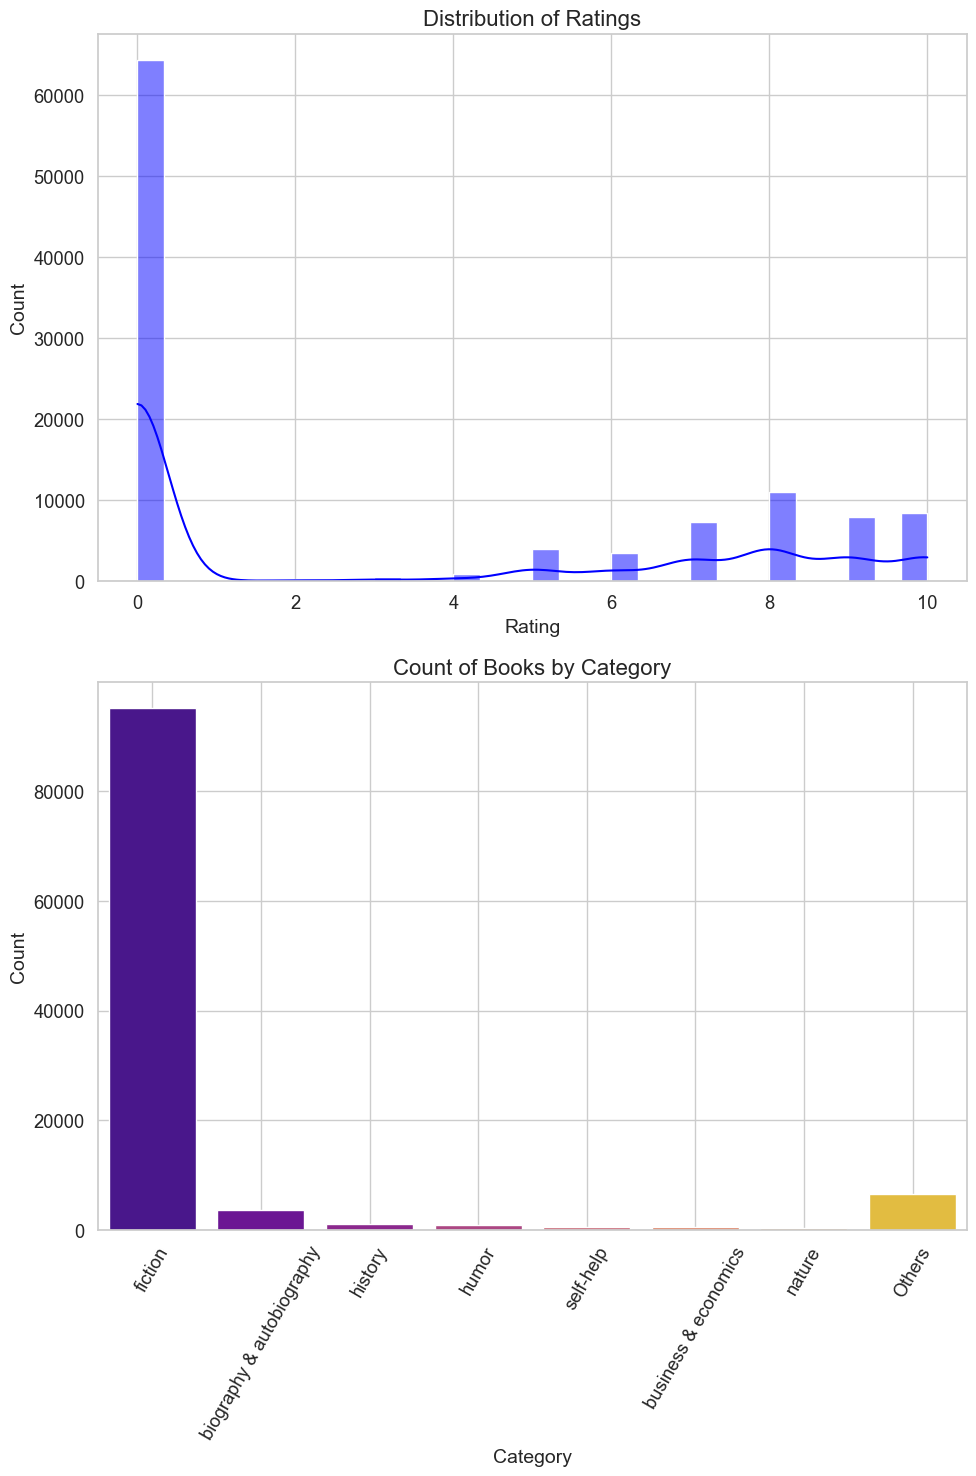

In [8]:
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Visualize the distribution of ratings and count of books by category
fig, axes = plt.subplots(2, 1, figsize=(10, 15))

# Distribution of ratings
sns.histplot(data=dataset, x='rating', kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Ratings', fontsize=16)
axes[0].set_xlabel('Rating', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].grid(True)

# Count of books by category
category_counts = dataset['Category'].value_counts()
top_categories = category_counts[:7]
other_categories_count = category_counts[7:].sum()
top_categories['Others'] = other_categories_count

sns.barplot(x=top_categories.index, y=top_categories.values, ax=axes[1], palette='plasma')
axes[1].set_title('Count of Books by Category', fontsize=16)
axes[1].set_xlabel('Category', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].tick_params(axis='x', rotation=60)
axes[1].grid(True)

plt.tight_layout()
plt.show()


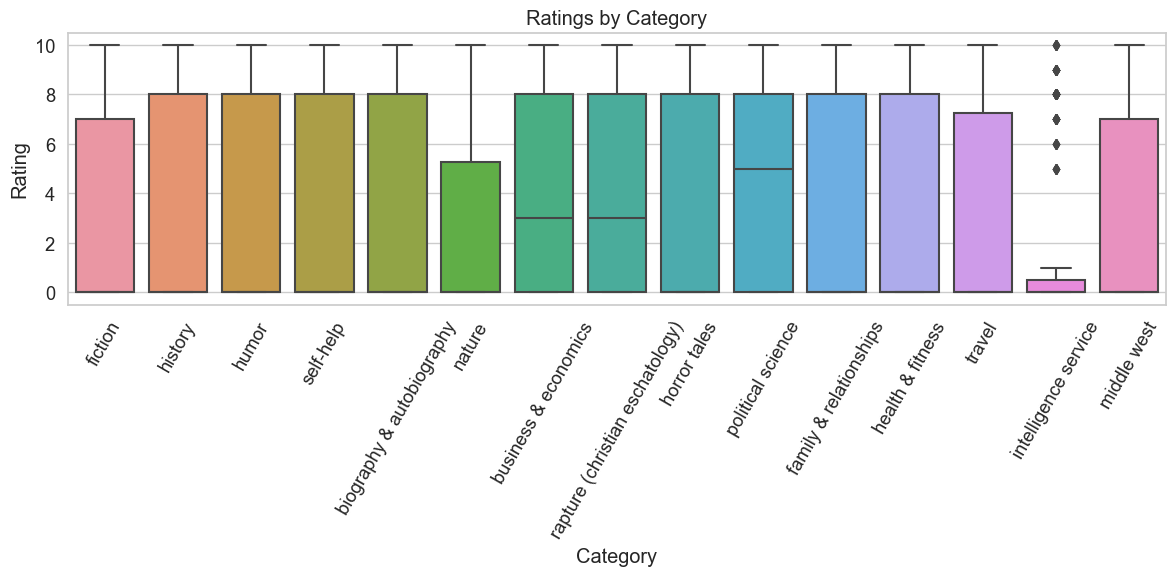

In [9]:
# Count the number of books in each category
category_counts = dataset['Category'].value_counts()

# Get the top 15 categories
top_categories = category_counts[:15]

# Aggregate the other categories as 'others'
other_categories_count = category_counts[15:].sum()
top_categories['Others'] = other_categories_count

# Plot the ratings by category
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=dataset[dataset['Category'].isin(top_categories.index)], x='Category', y='rating', ax=ax)

# Set the title, labels, and tick rotation
ax.set_title('Ratings by Category')
ax.set_xlabel('Category')
ax.set_ylabel('Rating')
ax.tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

### Recodificando os dados

É preciso recodificar os dados que sao do tipo 'string' para dados numéricos para que possa ser aplicado o algoritmo KNN. As colunas ```book_title```, ```book_author```, ```publisher``` e ```category``` receberão rótulos numéricos correspondentes a cada valor possível.

In [21]:
# Recodificando as colunas "book_title", "book_author", "publisher" e "category"
label_encoder_title = LabelEncoder()
label_encoder_author = LabelEncoder()
label_encoder_publisher = LabelEncoder()
label_encoder_category = LabelEncoder()


dataset['book_title_encoded'] = label_encoder_title.fit_transform(dataset['book_title'])
dataset['book_author_encoded'] = label_encoder_author.fit_transform(dataset['book_author'])
dataset['publisher_encoded'] = label_encoder_publisher.fit_transform(dataset['publisher'])
dataset['category_encoded'] = label_encoder_category.fit_transform(dataset['Category'])
dataset_encoded = dataset[[
    'year_of_publication','book_title_encoded',
    'book_author_encoded','publisher_encoded',
    'category_encoded',
    'rating'
    ]]

,rating,book_title,book_author,year_of_publication,publisher,Category,book_title_encoded,book_author_encoded,publisher_encoded,category_encoded
0,0,The Testament,John Grisham,1999.0,Dell,fiction,565,157,22,25
342,6,Beloved (Plume Contemporary Fiction),Toni Morrison,1994.0,Plume,fiction,64,316,78,25
487,0,Wild Animus,Rich Shapero,2004.0,Too Far,fiction,634,257,109,25
149412,0,Timeline,MICHAEL CRICHTON,2000.0,Ballantine Books,fiction,584,202,10,25
2501,9,Airframe,Michael Crichton,1997.0,Ballantine Books,fiction,34,218,10,25
...,...,...,...,...,...,...,...,...,...,...
20167,6,The Cider House Rules,John Irving,1994.0,Ballantine Books,fiction,433,158,10,25
158804,8,Life's Little Instruction Book (Life's Little ...,H. Jackson Brown,1991.0,Thomas Nelson,conduct of life,242,106,107,18
121791,0,The Cat Who Ate Danish Modern (Cat Who... (Pap...,Lilian Jackson Braun,1990.0,Jove Books,fiction,428,189,54,25
102551,7,Hornet's Nest,Patricia Daniels Cornwell,1998.0,Berkley Publishing Group,fiction,194,246,14,25


In [13]:
# # One-hot dummy encode para coluna 
# dataset_encoded = pd.get_dummies(dataset_encoded, drop_first=True)
dataset_encoded

,year_of_publication,book_title_encoded,book_author_encoded,publisher_encoded,category_encoded,rating
0,1999.0,565,157,22,25,0
342,1994.0,64,316,78,25,6
487,2004.0,634,257,109,25,0
149412,2000.0,584,202,10,25,0
2501,1997.0,34,218,10,25,9
...,...,...,...,...,...,...
20167,1994.0,433,158,10,25,6
158804,1991.0,242,106,107,18,8
121791,1990.0,428,189,54,25,0
102551,1998.0,194,246,14,25,7


# Normalizando as colunas para valores de 0 a 1

In [22]:
dataset_encoded = dataset_encoded/dataset_encoded.max()
dataset_encoded['rating'] = dataset['rating']
dataset_encoded

,year_of_publication,book_title_encoded,book_author_encoded,publisher_encoded,category_encoded,rating
0,0.997505,0.878694,0.477204,0.176,0.531915,0
342,0.995010,0.099533,0.960486,0.624,0.531915,6
487,1.000000,0.986003,0.781155,0.872,0.531915,0
149412,0.998004,0.908243,0.613982,0.080,0.531915,0
2501,0.996507,0.052877,0.662614,0.080,0.531915,9
...,...,...,...,...,...,...
20167,0.995010,0.673406,0.480243,0.080,0.531915,6
158804,0.993513,0.376361,0.322188,0.856,0.382979,8
121791,0.993014,0.665630,0.574468,0.432,0.531915,0
102551,0.997006,0.301711,0.747720,0.112,0.531915,7


---
### Divindo a base de dados em treino e teste

In [23]:
from sklearn.model_selection import train_test_split

# Split the dataset into training (80%) and testing (20%) sets
train_set, test_set = train_test_split(dataset_encoded, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", train_set.shape)
print("Testing set shape:", test_set.shape)

# Save the training and testing sets to CSV files
train_set.to_csv("dados_treinamento.csv", index=False)
test_set.to_csv("dados_teste.csv", index=False)

Training set shape: (86819, 6)
Testing set shape: (21705, 6)


---
## 3. Modelo baseado em KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Separate the features (X) and the target variable (y)
y_train = train_set["rating"]
X_train = train_set.drop(columns=["rating"],inplace=False)

y_test = test_set["rating"]
X_test = test_set.drop(columns=["rating"],inplace=False)

In [47]:
# Create the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
model = knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Testing the acuracy with de training data
y_pred_train = model.predict(X_train)

# Train data model acuracy
accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
print("Acurácia dados de treinamento:", accuracy_train)

# Test data model acuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Acurácia dados de teste:", accuracy)

Acurácia dados de treinamento: 0.5636439028323293
Acurácia dados de teste: 0.5560009214466712
0.9864400531128752


A acurácia do modelo com os dados de teste não é significativamente menor que a acurácia com os dados de treinamento. Isso mostra que provavelmente o modelo generalizou bem os dados. Foram realizados testes com diversos valores para o número de vizinhos mais próximos e para um número de vizinhos entre 5 e 20 o modelo tem diferenças menores que 2% de acurácia entre treino e teste.

---
## 4. Criando um modelo zero regra pela média dos dados

O modelo zero regra será composto somente pela média das avaliações para cada livro do dataset.

In [54]:
rating_means = train_set.groupby('book_title_encoded')['rating'].mean().round(0)
rating_medians = train_set.groupby('book_title_encoded')['rating'].median().round(0)
rating_modes = train_set.groupby('book_title_encoded')['rating'].median().round(0)

Usando esse dataframe com as medias das avaliações é possível prever as avaliacoes usando o modelo zero-regra

In [59]:
# Verificando a acuracia do modelo para os dados de treinamento:

y_train_zero_rule = train_set['rating']
y_train_predicted = train_set['book_title_encoded']

zero_rule_train = pd.merge(train_set[['book_title_encoded','rating']],rating_means,on='book_title_encoded',how='left')
zero_rule_train.rename(columns={'rating_x': 'rating', 'rating_y': 'predicted'}, inplace=True)

# Acuracia para os dados de treinamento
accuracy_train = (zero_rule_train['rating'] == zero_rule_train['predicted']).mean()

# Verificando a acuracia do modelo para os dados de teste:

y_test_zero_rule = test_set['rating']
y_test_predicted = test_set['book_title_encoded']

zero_rule_test = pd.merge(test_set[['book_title_encoded','rating']],rating_means,on='book_title_encoded',how='left')
zero_rule_test.rename(columns={'rating_x': 'rating', 'rating_y': 'predicted'}, inplace=True)

# Acuracia para os dados de treinamento
accuracy_test = (zero_rule_test['rating'] == zero_rule_test['predicted']).mean()

# Imprimindo resultados
print(f'Acurácia do modelo para dados de treino: {accuracy_train}')
print(f'Acurácia do modelo para os dados de teste: {accuracy_test}')


Acurácia do modelo para dados de treino: 0.006565383153457192
Acurácia do modelo para os dados de teste: 0.007141211702372725


Percebe-se que tanto para os dados de treino quanto para os dados de teste, o modelo tem acurácia menor que 1% nas previsões.

---
## Criando modelo zero regra pela moda dos dados

In [60]:
# Verificando a acuracia do modelo para os dados de treinamento:

y_train_zero_rule = train_set['rating']
y_train_predicted = train_set['book_title_encoded']

zero_rule_train = pd.merge(train_set[['book_title_encoded','rating']],rating_modes,on='book_title_encoded',how='left')
zero_rule_train.rename(columns={'rating_x': 'rating', 'rating_y': 'predicted'}, inplace=True)

# Acuracia para os dados de treinamento
accuracy_train = (zero_rule_train['rating'] == zero_rule_train['predicted']).mean()


# Verificando a acuracia do modelo para os dados de teste:

y_test_zero_rule = test_set['rating']
y_test_predicted = test_set['book_title_encoded']

zero_rule_test = pd.merge(test_set[['book_title_encoded','rating']],rating_modes,on='book_title_encoded',how='left')
zero_rule_test.rename(columns={'rating_x': 'rating', 'rating_y': 'predicted'}, inplace=True)

# Acuracia para os dados de treinamento
accuracy_test = (zero_rule_test['rating'] == zero_rule_test['predicted']).mean()

# Imprimindo resultados
print(f'Acurácia do modelo para dados de treino: {accuracy_train}')
print(f'Acurácia do modelo para os dados de teste: {accuracy_test}')


Acurácia do modelo para dados de treino: 0.5341111968578307
Acurácia do modelo para os dados de teste: 0.5228288412808109


---
## 5. Conclusões

Percebe-se que o modelo zero regra pela moda dos dados prevê consistentemente melhor que o modelo zero regra pela média dos dados. Isso provavelmente ocorreu devido ao desbalanceamento da base de dados com muitas avaliações com valor zero, fazendo com que a moda dos dados prevesse melhor que a média. Apesar disso, o modelo zero regra pela moda dos dados têm acurácia abaixo do modelo utilizando o método classificador KNN.